## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline

In [2]:
!wget https://www.lri.fr/~gcharpia/deeppractice/2022/TP1/house_prices.csv

--2024-08-20 21:28:53--  https://www.lri.fr/~gcharpia/deeppractice/2022/TP1/house_prices.csv
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33950 (33K) [text/csv]
Saving to: ‘house_prices.csv’

house_prices.csv    100%[===================>]  33.15K   136KB/s    in 0.2s    

2024-08-20 21:28:55 (136 KB/s) - ‘house_prices.csv’ saved [33950/33950]



In [3]:
# Load data:
df = pd.read_csv("house_prices.csv")

In [4]:
df.head(3)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
0,7,2003,856,1710,208500
1,6,1976,1262,1262,181500
2,7,2001,920,1786,223500


In [5]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   TotalBsmtSF  1460 non-null   int64
 3   GrLivArea    1460 non-null   int64
 4   SalePrice    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

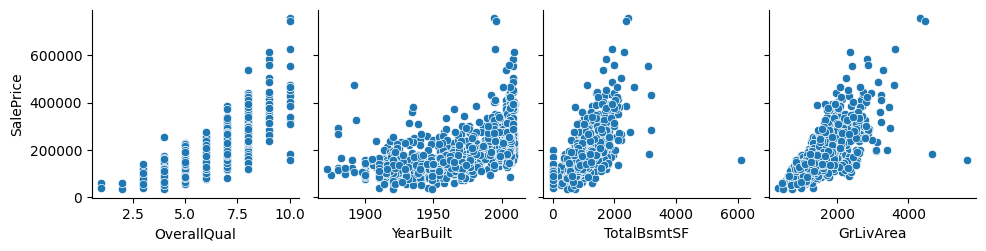

In [6]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'],
             y_vars=['SalePrice'])

### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [7]:
X = df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = df['SalePrice'] # get the target values

In [8]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]/100000 #Divide the output to avoid explosion in MSE (we learn output/C instead of output)

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]/100000

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]/100000

In [9]:
# Construct a model with one layer
class Model(nn.Module):

    def __init__(self,nb_hidden,nb_layers,activation):
        super(Model, self).__init__()

        self.layers = nn.ModuleList(
            [nn.BatchNorm1d(4),nn.Linear(4, nb_hidden),activation()] + \
            [nn.Linear(nb_hidden,nb_hidden),activation()] + \
            [nn.Linear(nb_hidden,1)]) #batchNorm input to avoid explosion (inputs can be huge)

        self.net = nn.Sequential(*self.layers)


    def forward(self, inputs):
        outputs = self.net(inputs)
        return outputs

In [10]:
# Define hyper-parameters:
model = Model(16,2,nn.ReLU)

# Choose the hyperparameters for training:
num_epochs = 100
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(),
                          torch.from_numpy(np.array(y_train)).float()) # creat the dataset.

In [12]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset,verbose=True):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):

            y_pre = model(X).view(-1)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)

        if ((epoch+1)%1 == 0) and verbose:
                print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss))


In [13]:
train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/100], Loss_error: 0.8559
Epoch [2/100], Loss_error: 0.2320
Epoch [3/100], Loss_error: 0.2409
Epoch [4/100], Loss_error: 0.2129
Epoch [5/100], Loss_error: 0.2393
Epoch [6/100], Loss_error: 0.2197
Epoch [7/100], Loss_error: 0.2093
Epoch [8/100], Loss_error: 0.2338
Epoch [9/100], Loss_error: 0.2076
Epoch [10/100], Loss_error: 0.2119
Epoch [11/100], Loss_error: 0.1997
Epoch [12/100], Loss_error: 0.2045
Epoch [13/100], Loss_error: 0.2014
Epoch [14/100], Loss_error: 0.2021
Epoch [15/100], Loss_error: 0.2042
Epoch [16/100], Loss_error: 0.2025
Epoch [17/100], Loss_error: 0.1815
Epoch [18/100], Loss_error: 0.2072
Epoch [19/100], Loss_error: 0.1908
Epoch [20/100], Loss_error: 0.2028
Epoch [21/100], Loss_error: 0.1928
Epoch [22/100], Loss_error: 0.2134
Epoch [23/100], Loss_error: 0.1863
Epoch [24/100], Loss_error: 0.1917
Epoch [25/100], Loss_error: 0.2039
Epoch [26/100], Loss_error: 0.1907
Epoch [27/100], Loss_error: 0.1754
Epoch [28/100], Loss_error: 0.1791
Epoch [29/100], Loss_error: 0

#### Evaluate the Model on the validation set

In [14]:
def evaluate(model,xset,yset):
    # Calculate mean squared error on validation set
    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(xset)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(yset)).float()).item()
    return -error

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error.

There is another loss function worth to try: the Gaussian likelihood loss function.
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function.

* Try to replace the loss function with this one, and compare the differences between the two losses.

* **Hints**:
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization)
    * Try deeper models, or you will not predict the variance $\sigma$ well.


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.

In [15]:
import time
def trial(nb_hidden,nb_layers,activation,lr,optimizer,num_epochs,batch_size,criterion):
    model = Model(nb_hidden,nb_layers,activation)

    # Training criterion. This one is a mean squared error (MSE) loss between the output
    # of the network and the target label
    criterion = criterion()

    # Use SGD optimizer with a learning rate of 0.01
    # It is initialized on our model
    optimizer = optimizer(model.parameters(), lr=lr)

    t = time.perf_counter()
    train(num_epochs, batch_size, criterion, optimizer, model, train_set,verbose=False)
    dt = time.perf_counter()-t

    val = evaluate(model,X_val,y_val)

    test = evaluate(model,X_test,y_test)

    return val,{'val':val,'test':test,'dt':dt}

In [16]:
!git clone https://github.com/Daetheys/ParameterOptimizer
%cd ParameterOptimizer

Cloning into 'ParameterOptimizer'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), done.
Resolving deltas: 100% (5/5), done.
/content/ParameterOptimizer


In [17]:
from optimizer import optimize
from compact_doc import compact_doc

In [18]:
params = {}
params['nb_hidden'] = [8,16,32,64,128]
params['nb_layers'] = [1,2,3,4,5]
params['activation'] = [nn.ReLU,nn.Tanh,nn.Sigmoid]
params['lr'] = [0.1,0.001,0.01,1,10]
params['optimizer']= [torch.optim.SGD,torch.optim.Adam,torch.optim.RMSprop]
params['num_epochs'] = [20,10,30,40]
params['batch_size'] = [10,20,100,500]
params['criterion'] = [nn.MSELoss]

In [19]:
optimal,doc = optimize(params,trial,nb_trials=5,nb_iteration=3)

nb_hidden
    8


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


    16


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


    32


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


    64


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


    128


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


nb_layers
    1


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


    2


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


    3


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


    4


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


    5


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


activation
    <class 'torch.nn.modules.activation.ReLU'>


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


    <class 'torch.nn.modules.activation.Tanh'>


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


    <class 'torch.nn.modules.activation.Sigmoid'>


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


lr
    0.1


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


    0.001


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


    0.01


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


    1


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


    10


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


optimizer
    <class 'torch.optim.sgd.SGD'>


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


    <class 'torch.optim.adam.Adam'>


100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


    <class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


num_epochs
    20


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


    10


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


    30


100%|██████████| 5/5 [00:19<00:00,  3.94s/it]


    40


100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


batch_size
    10


100%|██████████| 5/5 [00:22<00:00,  4.60s/it]


    20


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


    100


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


    500


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


criterion
    <class 'torch.nn.modules.loss.MSELoss'>


100%|██████████| 5/5 [00:20<00:00,  4.16s/it]


nb_hidden
    8


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


    16


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


    32


100%|██████████| 5/5 [00:19<00:00,  3.91s/it]


    64


100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


    128


100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


nb_layers
    1


100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


    2


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


    3


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


    4


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


    5


100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


activation
    <class 'torch.nn.modules.activation.ReLU'>


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


    <class 'torch.nn.modules.activation.Tanh'>


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


    <class 'torch.nn.modules.activation.Sigmoid'>


100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


lr
    0.1


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


    0.001


100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


    0.01


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


    1


100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


    10


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


optimizer
    <class 'torch.optim.sgd.SGD'>


100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


    <class 'torch.optim.adam.Adam'>


100%|██████████| 5/5 [00:37<00:00,  7.45s/it]


    <class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


num_epochs
    20


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


    10


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


    30


100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


    40


100%|██████████| 5/5 [00:27<00:00,  5.59s/it]


batch_size
    10


100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


    20


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


    100


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


    500


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


criterion
    <class 'torch.nn.modules.loss.MSELoss'>


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


nb_hidden
    8


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


    16


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


    32


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


    64


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


    128


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


nb_layers
    1


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


    2


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


    3


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


    4


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


    5


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


activation
    <class 'torch.nn.modules.activation.ReLU'>


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


    <class 'torch.nn.modules.activation.Tanh'>


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


    <class 'torch.nn.modules.activation.Sigmoid'>


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


lr
    0.1


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


    0.001


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


    0.01


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


    1


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


    10


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


optimizer
    <class 'torch.optim.sgd.SGD'>


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


    <class 'torch.optim.adam.Adam'>


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


    <class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


num_epochs
    20


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


    10


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


    30


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


    40


100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


batch_size
    10


100%|██████████| 5/5 [00:27<00:00,  5.44s/it]


    20


100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


    100


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


    500


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


criterion
    <class 'torch.nn.modules.loss.MSELoss'>


100%|██████████| 5/5 [00:27<00:00,  5.46s/it]


In [20]:
optimal,compact_doc(doc)

({'nb_hidden': 64,
  'nb_layers': 4,
  'activation': torch.nn.modules.activation.ReLU,
  'lr': 0.01,
  'optimizer': torch.optim.sgd.SGD,
  'num_epochs': 40,
  'batch_size': 10,
  'criterion': torch.nn.modules.loss.MSELoss},
 {'nb_hidden': {8: {'val': -0.11624101251363753,
    'test': -0.2703814297914505,
    'dt': 2.1583290867999496},
   16: {'val': -0.11106414198875426,
    'test': -0.2740072995424271,
    'dt': 2.194262480999987},
   32: {'val': -0.11420551538467408,
    'test': -0.25898059010505675,
    'dt': 2.0197885475998647},
   64: {'val': -0.10157180726528167,
    'test': -0.2664705038070679,
    'dt': 2.256518537399916},
   128: {'val': -0.11013522297143936,
    'test': -0.2526859849691391,
    'dt': 2.3637444962000242}},
  'nb_layers': {1: {'val': -0.10375754386186599,
    'test': -0.25944543480873106,
    'dt': 2.2668124317999627},
   2: {'val': -0.11217548251152037,
    'test': -0.2609983205795288,
    'dt': 2.243936451199988},
   3: {'val': -0.10790036022663116,
    'test